# RoPE 的基本实现

In [14]:
import torch
from einops import rearrange
from torch import einsum, nn

class RotaryEmbedding(nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None):
        super().__init__()

        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base
        inv_freq = 1.0 / (self.base ** (torch.arange(0, self.dim, 2).float().to(device) / self.dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)

        # Build here to make `torch.jit.trace` work.
        self._set_cos_sin_cache(
            seq_len=max_position_embeddings, device=self.inv_freq.device, dtype=torch.get_default_dtype()
        )
        self.max_seq_len_cached = None


    def _set_cos_sin_cache(self, seq_len, device, dtype):
        self.max_seq_len_cached = seq_len
        t = torch.arange(self.max_seq_len_cached, device=device, dtype=self.inv_freq.dtype)

        freqs = torch.outer(t, self.inv_freq.to(t.device))
        # Different from paper, but it uses a different permutation in order to obtain the same calculation
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer("cos_cached", emb.cos().to(dtype), persistent=False)
        self.register_buffer("sin_cached", emb.sin().to(dtype), persistent=False)

    def forward(self, x, seq_len=None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        if self.max_seq_len_cached is None or seq_len > self.max_seq_len_cached:
            self._set_cos_sin_cache(seq_len=seq_len, device=x.device, dtype=x.dtype)

        return (
            self.cos_cached[:seq_len].to(dtype=x.dtype),
            self.sin_cached[:seq_len].to(dtype=x.dtype),
        )



def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, position_ids, unsqueeze_dim=1):
    cos = cos[position_ids].unsqueeze(unsqueeze_dim)
    sin = sin[position_ids].unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed



# (bs, head, length, dim)
q = torch.randn((2, 12, 10, 32))  # q=[q0, q1, .., qd-1]
k = torch.randn((2, 12, 10, 32))
v = torch.randn((2, 12, 10, 32))
position_ids = torch.tensor(list(range(0, 10))).unsqueeze(0).repeat(2, 1)
print('q:', q[0][0][0])
print('k:', k[0][0][0])
rotary_emb = RotaryEmbedding(dim=32,max_position_embeddings=10)
cos, sin = rotary_emb(v, seq_len=10)
q_new, k_new = apply_rotary_pos_emb(q, k, cos, sin, position_ids)
print('q_new: ', q_new[0][0][0])
print('k_new: ', k_new[0][0][0])


q: tensor([-0.8693,  0.4781,  0.4930,  0.3517,  0.5757,  1.3502,  0.5328,  0.7492,
         0.9513,  1.0622,  0.7053, -1.2464,  0.3049,  1.3211, -0.1932, -1.1134,
        -0.9362, -0.3564,  0.4437, -1.3673, -1.9310, -0.4882,  1.4058, -1.7312,
         1.0709, -0.4552,  0.7468,  0.7438,  0.6434, -1.0748,  1.8548,  1.5585])
k: tensor([-1.1803, -0.5337, -1.5437,  0.6127,  1.1359, -0.9194,  1.1197, -0.1602,
         1.0030, -0.6805, -1.9937, -0.1422, -0.1050, -1.1119,  0.2273, -0.9511,
         0.6840,  0.8177, -1.0660, -0.9559, -0.2572,  0.2468,  0.3948,  1.3562,
         0.2670,  0.7595, -0.8655,  0.5448,  1.9273,  0.3699, -1.2218, -0.8015])
q_new:  tensor([-0.8693,  0.4781,  0.4930,  0.3517,  0.5757,  1.3502,  0.5328,  0.7492,
         0.9513,  1.0622,  0.7053, -1.2464,  0.3049,  1.3211, -0.1932, -1.1134,
        -0.9362, -0.3564,  0.4437, -1.3673, -1.9310, -0.4882,  1.4058, -1.7312,
         1.0709, -0.4552,  0.7468,  0.7438,  0.6434, -1.0748,  1.8548,  1.5585])
k_new:  tensor([-1.1803

## RoPE 的远程衰减

- 除了 base=1 外，均有明显的远程衰减特性
- base 越小，衰减得越快且幅度也更大
- base 越大，衰减得越慢且幅度也越小

/Users/fromeast/anaconda3/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:577: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


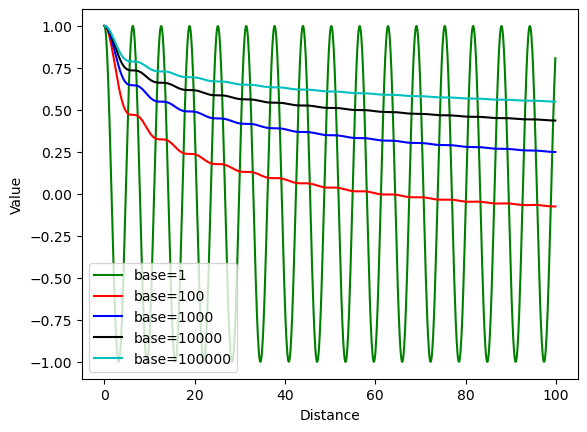

In [6]:
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt

def integrand(t, dis, base=10000):
    return np.exp(1j * dis * base**(-t))

def plot():
    x = np.arange(0, 100, 0.1)
    base_list = [1, 100, 1000, 10000, 100000]
    y = np.zeros((len(base_list),len(x)))
    for b in range(len(base_list)):
        n = base_list[b]
        for i in range(len(x)):
            res, err=quad(integrand, 0, 1, args=(x[i],n))
            y[b][i]=res
            
    plt.plot(x, y[0], 'g', label='base='+str(base_list[0]))
    plt.plot(x, y[1], 'r', label='base='+str(base_list[1]))
    plt.plot(x, y[2], 'b', label='base='+str(base_list[2]))
    plt.plot(x, y[3], 'k', label='base='+str(base_list[3]))
    plt.plot(x, y[4], 'c', label='base='+str(base_list[4]))
    
    plt.xlabel('Distance')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

plot()

## 线性插值的实现

In [13]:
class LinearScaledRotaryEmbedding(torch.nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base=10000, scale=1, device=None):
        super().__init__()
        # 相比RoPE增加scale参数
        self.scale = scale
        # inv_freq为基值向量
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float().to(device) / dim))
        self.register_buffer("inv_freq", inv_freq)

        # Build here to make `torch.jit.trace` work.
        self.max_seq_len_cached = max_position_embeddings
        # 构建max_seq_len_cached大小的张量t
        t = torch.arange(self.max_seq_len_cached, device=self.inv_freq.device, dtype=self.inv_freq.dtype)
        # 张量t归一化，RoPE没有这一步
        t /= self.scale
        # einsum计算频率矩阵
        # 'i, j->i j’表示分别输入尺寸为[i]、[j]的向量，做笛卡尔运算得到尺寸为[i, j]的矩阵。
        freqs = torch.einsum("i,j->ij", t, self.inv_freq)
        # Different from paper, but it uses a different permutation in order to obtain the same calculation
        # 在-1维做一次拷贝、拼接
        emb = torch.cat((freqs, freqs), dim=-1)
        dtype = torch.get_default_dtype()
        # 注册为模型的缓冲区cos_cached和sin_cached
        self.register_buffer("cos_cached", emb.cos().to(dtype), persistent=False)
        self.register_buffer("sin_cached", emb.sin().to(dtype), persistent=False)

    def forward(self, x, seq_len=None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        # This `if` block is unlikely to be run after we build sin/cos in `__init__`. Keep the logic here just in case.
        # seq_len为序列长度，seq_len大于max_seq_len_cached，则重新计算频率矩阵，并更新cos_cached和sin_cached的缓冲区
        if seq_len > self.max_seq_len_cached:
            self.max_seq_len_cached = seq_len
            t = torch.arange(self.max_seq_len_cached, device=x.device, dtype=self.inv_freq.dtype)
            t /= self.scale
            freqs = torch.einsum("i,j->ij", t, self.inv_freq)
            # Different from paper, but it uses a different permutation in order to obtain the same calculation
            emb = torch.cat((freqs, freqs), dim=-1).to(x.device)
            self.register_buffer("cos_cached", emb.cos().to(x.dtype), persistent=False)
            self.register_buffer("sin_cached", emb.sin().to(x.dtype), persistent=False)
        # 长度裁剪：返回cos_cached和sin_cached中与seq_len（序列长度）
        return (
            self.cos_cached[:seq_len].to(dtype=x.dtype),
            self.sin_cached[:seq_len].to(dtype=x.dtype),
        )
    
# (bs, head, length, dim)
q = torch.randn((2, 12, 10, 32))  # q=[q0, q1, .., qd-1]
k = torch.randn((2, 12, 10, 32))
v = torch.randn((2, 12, 10, 32))
position_ids = torch.tensor(list(range(0, 10))).unsqueeze(0).repeat(2, 1)
print('q:', q[0][0][0])
print('k:', k[0][0][0])
rotary_emb = LinearScaledRotaryEmbedding(dim=32, max_position_embeddings=10, scale=2)
cos, sin = rotary_emb(v, seq_len=20)

q_new, k_new = apply_rotary_pos_emb(q, k, cos, sin, position_ids)
print('q_new: ', q_new[0][0][0])
print('k_new: ', k_new[0][0][0])

q: tensor([-0.7386,  0.3126, -0.6404, -1.1976,  0.1745,  0.8204,  1.9868, -2.1083,
         1.7011,  0.8929,  0.0727,  0.2456,  0.3690,  1.4194,  0.9576, -1.9760,
        -0.2564,  0.9356,  1.2557,  0.6416,  1.2461,  0.4018,  0.1794,  0.1308,
        -0.0078,  0.8118,  1.4571,  0.1142,  1.2326, -0.7917, -2.3047, -0.0602])
k: tensor([-0.6328,  0.1178, -1.1089,  1.5455,  0.9656, -0.1420,  0.4648, -1.4591,
        -0.9455,  0.3302, -0.5119, -1.4733, -1.2549, -0.1893,  0.7730, -0.3901,
         0.0137,  0.3142, -0.6838,  0.4591,  0.5648, -0.1194,  0.8176, -1.2282,
         0.1147, -0.3555,  0.0753,  0.1046, -0.5155, -1.0724, -0.0387, -0.7406])
q_new:  tensor([-0.7386,  0.3126, -0.6404, -1.1976,  0.1745,  0.8204,  1.9868, -2.1083,
         1.7011,  0.8929,  0.0727,  0.2456,  0.3690,  1.4194,  0.9576, -1.9760,
        -0.2564,  0.9356,  1.2557,  0.6416,  1.2461,  0.4018,  0.1794,  0.1308,
        -0.0078,  0.8118,  1.4571,  0.1142,  1.2326, -0.7917, -2.3047, -0.0602])
k_new:  tensor([-0.6328

## NTK aware 外推的实现

In [16]:
class NTKScaledRotaryEmbedding(torch.nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base=10000, alpha=1, device=None):
        super().__init__()
        # 与线性插值法相比，实现更简单，alpha仅用来改变base
        base = base * alpha ** (dim / (dim-2))
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float().to(device) / dim))
        self.register_buffer("inv_freq", inv_freq)

        # Build here to make `torch.jit.trace` work.
        self.max_seq_len_cached = max_position_embeddings
        t = torch.arange(self.max_seq_len_cached, device=self.inv_freq.device, dtype=self.inv_freq.dtype)
        freqs = torch.einsum("i,j->ij", t, self.inv_freq)
        # Different from paper, but it uses a different permutation in order to obtain the same calculation
        emb = torch.cat((freqs, freqs), dim=-1)
        dtype = torch.get_default_dtype()
        self.register_buffer("cos_cached", emb.cos().to(dtype), persistent=False)
        self.register_buffer("sin_cached", emb.sin().to(dtype), persistent=False)

    def forward(self, x, seq_len=None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        # This `if` block is unlikely to be run after we build sin/cos in `__init__`. Keep the logic here just in case.
        if seq_len > self.max_seq_len_cached:
            self.max_seq_len_cached = seq_len
            t = torch.arange(self.max_seq_len_cached, device=x.device, dtype=self.inv_freq.dtype)
            freqs = torch.einsum("i,j->ij", t, self.inv_freq)
            # Different from paper, but it uses a different permutation in order to obtain the same calculation
            emb = torch.cat((freqs, freqs), dim=-1).to(x.device)
            self.register_buffer("cos_cached", emb.cos().to(x.dtype), persistent=False)
            self.register_buffer("sin_cached", emb.sin().to(x.dtype), persistent=False)
        return (
            self.cos_cached[:seq_len].to(dtype=x.dtype),
            self.sin_cached[:seq_len].to(dtype=x.dtype),
        )
    
# (bs, head, length, dim)
q = torch.randn((2, 12, 10, 32))  # q=[q0, q1, .., qd-1]
k = torch.randn((2, 12, 10, 32))
v = torch.randn((2, 12, 10, 32))
position_ids = torch.tensor(list(range(0, 10))).unsqueeze(0).repeat(2, 1)
print('q:', q[0][0][0])
print('k:', k[0][0][0])
rotary_emb = NTKScaledRotaryEmbedding(dim=32, max_position_embeddings=10, alpha=10)
cos, sin = rotary_emb(v, seq_len=20)

q_new, k_new = apply_rotary_pos_emb(q, k, cos, sin, position_ids)
print('q_new: ', q_new[0][0][0])
print('k_new: ', k_new[0][0][0])

q: tensor([-2.0356,  0.5335, -0.2943,  2.2030, -0.5060,  0.3836,  0.8608,  0.5533,
         0.6158,  0.9927, -0.7878, -0.3978,  0.3661,  1.1224, -1.8043, -0.7314,
        -1.3826, -1.5953,  0.4749, -0.7502,  0.8913, -1.2234, -0.1037,  0.2985,
        -0.5934,  1.3392, -0.2031, -1.2564, -0.6747, -0.9470, -0.7968, -0.1576])
k: tensor([ 0.2242,  0.7023, -0.5397, -1.2178,  0.9707,  0.7650, -1.0225, -0.8561,
        -1.3768, -1.4814,  0.9796, -0.2181, -1.2774,  1.9119,  1.5775,  0.5692,
        -0.7546, -2.0346, -0.6144, -0.1261,  2.2313, -0.1916,  2.5680,  0.5018,
        -0.0589, -1.0014, -0.6470,  0.1474, -1.3001,  0.2115, -0.7482,  0.3008])
q_new:  tensor([-2.0356,  0.5335, -0.2943,  2.2030, -0.5060,  0.3836,  0.8608,  0.5533,
         0.6158,  0.9927, -0.7878, -0.3978,  0.3661,  1.1224, -1.8043, -0.7314,
        -1.3826, -1.5953,  0.4749, -0.7502,  0.8913, -1.2234, -0.1037,  0.2985,
        -0.5934,  1.3392, -0.2031, -1.2564, -0.6747, -0.9470, -0.7968, -0.1576])
k_new:  tensor([ 0.2242

## Dynaimic NTK 外推的实现

In [17]:
class DynamicScaledRotaryEmbedding(torch.nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base=10000, ntk=False, device=None):
        super().__init__()
        # 是否开启NTK（Neural Tangent Kernel）
        self.ntk = ntk
        self.base = base
        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        # inv_freq为基值向量
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float().to(device) / dim))
        self.register_buffer("inv_freq", inv_freq)

        # Build here to make `torch.jit.trace` work.
        self.max_seq_len_cached = max_position_embeddings
        t = torch.arange(self.max_seq_len_cached, device=self.inv_freq.device, dtype=self.inv_freq.dtype)
        freqs = torch.einsum("i,j->ij", t, self.inv_freq)
        # Different from paper, but it uses a different permutation in order to obtain the same calculation
        # emb：[max_seq_len_cached, dim]
        emb = torch.cat((freqs, freqs), dim=-1)
        dtype = torch.get_default_dtype()
        self.register_buffer("cos_cached", emb.cos().to(dtype), persistent=False)
        self.register_buffer("sin_cached", emb.sin().to(dtype), persistent=False)

    def forward(self, x, seq_len=None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        # This `if` block is unlikely to be run after we build sin/cos in `__init__`. Keep the logic here just in case.
        if seq_len > self.max_seq_len_cached:
            self.max_seq_len_cached = seq_len
            if self.ntk:
                base = self.base * ((self.ntk * seq_len / self.max_position_embeddings) - (self.ntk - 1)) ** (self.dim / (self.dim-2))
                # 计算新的inv_freq
                inv_freq = 1.0 / (base ** (torch.arange(0, self.dim, 2).float().to(x.device) / self.dim))
                self.register_buffer("inv_freq", inv_freq)
            t = torch.arange(self.max_seq_len_cached, device=x.device, dtype=self.inv_freq.dtype)
            if not self.ntk:
                # 缩放
                t *= self.max_position_embeddings / seq_len
            # 得到新的频率矩阵freqs
            freqs = torch.einsum("i,j->ij", t, self.inv_freq)
            # Different from paper, but it uses a different permutation in order to obtain the same calculation
            # freqs与自身拼接得到新的emb
            emb = torch.cat((freqs, freqs), dim=-1).to(x.device)
            # 注册为模型的缓冲区cos_cached和sin_cached
            self.register_buffer("cos_cached", emb.cos().to(x.dtype), persistent=False)
            self.register_buffer("sin_cached", emb.sin().to(x.dtype), persistent=False)

        # 长度裁剪
        return (
            self.cos_cached[:seq_len].to(dtype=x.dtype),
            self.sin_cached[:seq_len].to(dtype=x.dtype),
        )
    
# (bs, head, length, dim)
q = torch.randn((2, 12, 10, 32))  # q=[q0, q1, .., qd-1]
k = torch.randn((2, 12, 10, 32))
v = torch.randn((2, 12, 10, 32))
position_ids = torch.tensor(list(range(0, 10))).unsqueeze(0).repeat(2, 1)
print('q:', q[0][0][0])
print('k:', k[0][0][0])
rotary_emb = DynamicScaledRotaryEmbedding(dim=32, max_position_embeddings=10, ntk=True)
cos, sin = rotary_emb(v, seq_len=20)

q_new, k_new = apply_rotary_pos_emb(q, k, cos, sin, position_ids)
print('q_new: ', q_new[0][0][0])
print('k_new: ', k_new[0][0][0])

q: tensor([-1.0314,  0.3475,  0.6054,  0.4758,  0.2080, -0.1064, -0.2559, -1.2432,
        -1.2669, -0.8704, -1.3891,  0.5940, -0.5314, -1.0073,  0.5326, -0.9410,
         0.6888, -0.2143, -0.8900, -0.5465, -0.8815,  0.8723, -0.0125, -1.6313,
         0.1018,  0.7021, -0.5169, -0.1331, -1.0006,  0.1864,  0.2876, -0.9891])
k: tensor([ 1.5224, -1.2986, -0.5644, -0.5807,  2.1788, -0.2760, -0.6890,  0.4139,
        -0.0151, -1.4198,  0.6517,  0.2883, -0.7820, -0.2261, -0.7961, -1.7140,
        -0.9996,  0.2228, -0.5026, -1.3464, -0.1856,  2.9333,  1.4121,  0.6357,
         0.4330, -2.9884,  1.1371,  0.5648,  1.5028,  0.8673,  0.1810,  0.6892])
q_new:  tensor([-1.0314,  0.3475,  0.6054,  0.4758,  0.2080, -0.1064, -0.2559, -1.2432,
        -1.2669, -0.8704, -1.3891,  0.5940, -0.5314, -1.0073,  0.5326, -0.9410,
         0.6888, -0.2143, -0.8900, -0.5465, -0.8815,  0.8723, -0.0125, -1.6313,
         0.1018,  0.7021, -0.5169, -0.1331, -1.0006,  0.1864,  0.2876, -0.9891])
k_new:  tensor([ 1.5224